In [1]:
# Add all necessary imports here
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import IFrame
%matplotlib inline
plt.style.reload_library()
plt.style.use("seaborn-dark-palette")

# Matplotlib +  mpld3
https://matplotlib.org/ | http://mpld3.github.io/

In [4]:
import jinja2
import json
import mpld3
from mpld3 import plugins, utils
mpld3.enable_notebook()

In [5]:
class HighlightLines(plugins.PluginBase):
    """A plugin to highlight lines on hover"""

    JAVASCRIPT = """
    mpld3.register_plugin("linehighlight", LineHighlightPlugin);
    LineHighlightPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LineHighlightPlugin.prototype.constructor = LineHighlightPlugin;
    LineHighlightPlugin.prototype.requiredProps = ["line_ids"];
    LineHighlightPlugin.prototype.defaultProps = {alpha_bg:0.3, alpha_fg:1.0}
    function LineHighlightPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LineHighlightPlugin.prototype.draw = function(){
      for(var i=0; i<this.props.line_ids.length; i++){
         var obj = mpld3.get_element(this.props.line_ids[i], this.fig),
             alpha_fg = this.props.alpha_fg;
             alpha_bg = this.props.alpha_bg;
         obj.elements()
             .on("mouseover", function(d, i){
                            d3.select(this).transition().duration(50)
                              .style("stroke-opacity", alpha_fg); })
             .on("mouseout", function(d, i){
                            d3.select(this).transition().duration(200)
                              .style("stroke-opacity", alpha_bg); });
      }
    };
    """

    def __init__(self, lines):
        self.lines = lines
        self.dict_ = {"type": "linehighlight",
                      "line_ids": [utils.get_id(line) for line in lines],
                      "alpha_bg": lines[0].get_alpha(),
                      "alpha_fg": 1.0}


def create_random_walk():
    N_paths = 50
    N_steps = 100

    x = np.linspace(0, 10, 100)
    y = 0.1 * (np.random.random((N_paths, N_steps)) - 0.5)
    y = y.cumsum(1)

    fig, ax = plt.subplots(subplot_kw={'xticks': [], 'yticks': []}, figsize=(8, 5))
    lines = ax.plot(x, y.T, color='blue', lw=4, alpha=0.1)
    plugins.connect(fig, HighlightLines(lines))

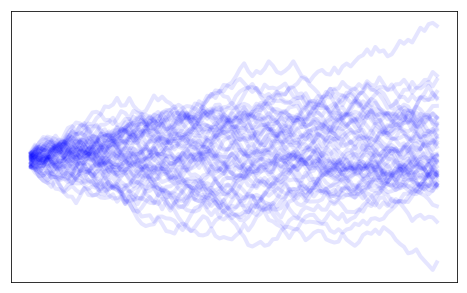

In [6]:
create_random_walk()

In [7]:
def create_scatter_plot():
    fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(8, 8))
    ax.grid(color='white', linestyle='solid')

    N = 50
    scatter = ax.scatter(np.random.normal(size=N),
                         np.random.normal(size=N),
                         c=np.random.random(size=N),
                         s = 1000 * np.random.random(size=N),
                         alpha=0.3,
                         cmap=plt.cm.jet)

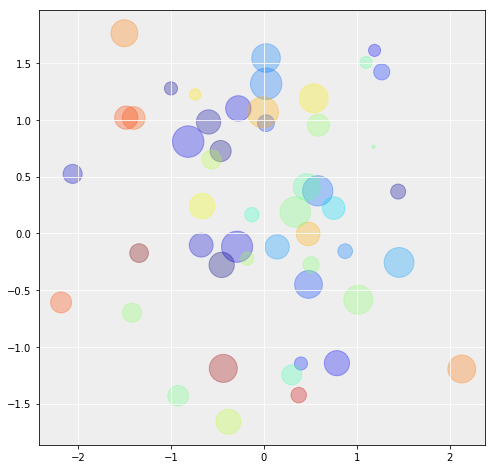

In [8]:
create_scatter_plot()

In [9]:
def create_curve_plot():
    fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(8, 5))
    x = np.linspace(0, 10, 1000)
    for offset in np.linspace(0, 3, 7):
        ax.plot(x, 0.9 * np.sin(x - offset), lw=5, alpha=0.4)
    ax.set_ylim(-1.2, 1.0)
    ax.grid(color='lightgray', alpha=0.7)

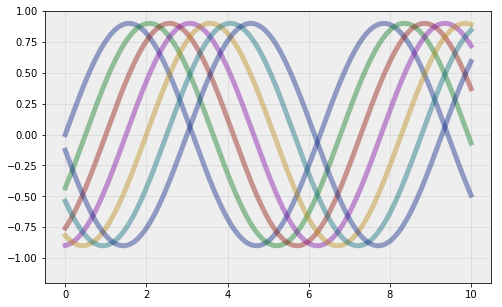

In [10]:
create_curve_plot()

In [2]:
from mpl_toolkits.mplot3d import Axes3D

def plot_meshgrid():
    fig = plt.figure()
    ax = Axes3D(fig)
    X = np.arange(-4, 4, 0.25)
    Y = np.arange(-4, 4, 0.25)
    X, Y = np.meshgrid(X, Y)
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='hot')

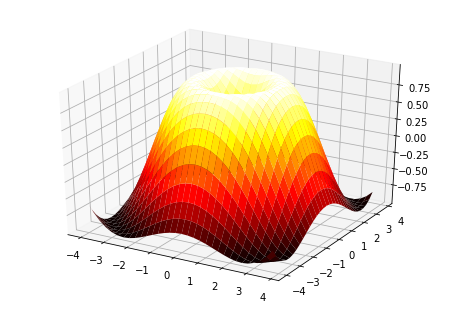

In [3]:
plot_meshgrid()

# Bokeh
http://bokeh.pydata.org/en/latest/

In [11]:
from collections import OrderedDict
from math import log, sqrt

import numpy as np
import pandas as pd
from six.moves import cStringIO as StringIO

from bokeh.plotting import figure, show, output_file

antibiotics = """
bacteria,                        penicillin, streptomycin, neomycin, gram
Mycobacterium tuberculosis,      800,        5,            2,        negative
Salmonella schottmuelleri,       10,         0.8,          0.09,     negative
Proteus vulgaris,                3,          0.1,          0.1,      negative
Klebsiella pneumoniae,           850,        1.2,          1,        negative
Brucella abortus,                1,          2,            0.02,     negative
Pseudomonas aeruginosa,          850,        2,            0.4,      negative
Escherichia coli,                100,        0.4,          0.1,      negative
Salmonella (Eberthella) typhosa, 1,          0.4,          0.008,    negative
Aerobacter aerogenes,            870,        1,            1.6,      negative
Brucella antracis,               0.001,      0.01,         0.007,    positive
Streptococcus fecalis,           1,          1,            0.1,      positive
Staphylococcus aureus,           0.03,       0.03,         0.001,    positive
Staphylococcus albus,            0.007,      0.1,          0.001,    positive
Streptococcus hemolyticus,       0.001,      14,           10,       positive
Streptococcus viridans,          0.005,      10,           40,       positive
Diplococcus pneumoniae,          0.005,      11,           10,       positive
"""

drug_color = OrderedDict([
    ("Penicillin",   "#0d3362"),
    ("Streptomycin", "#c64737"),
    ("Neomycin",     "black"  ),
])

gram_color = {
    "positive" : "#aeaeb8",
    "negative" : "#e69584",
}

df = pd.read_csv(StringIO(antibiotics),
                 skiprows=1,
                 skipinitialspace=True,
                 engine='python')

width = 500
height = 500
inner_radius = 90
outer_radius = 300 - 10

minr = sqrt(log(.001 * 1E4))
maxr = sqrt(log(1000 * 1E4))
a = (outer_radius - inner_radius) / (minr - maxr)
b = inner_radius - a * maxr

def rad(mic):
    return a * np.sqrt(np.log(mic * 1E4)) + b

big_angle = 2.0 * np.pi / (len(df) + 1)
small_angle = big_angle / 7

p = figure(plot_width=width, plot_height=height, title="",
    x_axis_type=None, y_axis_type=None,
    x_range=(-420, 420), y_range=(-420, 420),
    min_border=0, outline_line_color="black",
    background_fill_color="#f0e1d2", border_fill_color="#f0e1d2",
    toolbar_sticky=False)

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

# annular wedges
angles = np.pi/2 - big_angle/2 - df.index.to_series()*big_angle
colors = [gram_color[gram] for gram in df.gram]
p.annular_wedge(
    0, 0, inner_radius, outer_radius, -big_angle+angles, angles, color=colors,
)

# small wedges
p.annular_wedge(0, 0, inner_radius, rad(df.penicillin),
                -big_angle+angles+5*small_angle, -big_angle+angles+6*small_angle,
                color=drug_color['Penicillin'])
p.annular_wedge(0, 0, inner_radius, rad(df.streptomycin),
                -big_angle+angles+3*small_angle, -big_angle+angles+4*small_angle,
                color=drug_color['Streptomycin'])
p.annular_wedge(0, 0, inner_radius, rad(df.neomycin),
                -big_angle+angles+1*small_angle, -big_angle+angles+2*small_angle,
                color=drug_color['Neomycin'])

# circular axes and lables
labels = np.power(10.0, np.arange(-3, 4))
radii = a * np.sqrt(np.log(labels * 1E4)) + b
p.circle(0, 0, radius=radii, fill_color=None, line_color="white")
p.text(0, radii[:-1], [str(r) for r in labels[:-1]],
       text_font_size="6pt", text_align="center", text_baseline="middle")

# radial axes
p.annular_wedge(0, 0, inner_radius-10, outer_radius+10,
                -big_angle+angles, -big_angle+angles, color="black")

# bacteria labels
xr = radii[0]*np.cos(np.array(-big_angle/2 + angles))
yr = radii[0]*np.sin(np.array(-big_angle/2 + angles))
label_angle=np.array(-big_angle/2+angles)
label_angle[label_angle < -np.pi/2] += np.pi # easier to read labels on the left side
p.text(xr, yr, df.bacteria, angle=label_angle,
       text_font_size="5pt", text_align="center", text_baseline="middle")

# OK, these hand drawn legends are pretty clunky, will be improved in future release
p.circle([-40, -40], [-370, -390], color=list(gram_color.values()), radius=5)
p.text([-30, -30], [-370, -390], text=["Gram-" + gr for gr in gram_color.keys()],
       text_font_size="5pt", text_align="left", text_baseline="middle")

p.rect([-40, -40, -40], [18, 0, -18], width=30, height=13,
       color=list(drug_color.values()))
p.text([-15, -15, -15], [18, 0, -18], text=list(drug_color),
       text_font_size="5pt", text_align="left", text_baseline="middle")

output_file("burtin.html", title="burtin.py example")

show(p)

In [12]:
IFrame('burtin.html', width=700, height=500)

In [13]:
import numpy as np

from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource

x = np.linspace(0, 10, 500)
y = np.sin(x)

source = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(y_range=(-10, 10), plot_width=400, plot_height=400)

plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var A = amp.value;
    var k = freq.value;
    var phi = phase.value;
    var B = offset.value;
    x = data['x']
    y = data['y']
    for (i = 0; i < x.length; i++) {
        y[i] = B + A*Math.sin(k*x[i]+phi);
    }
    source.change.emit();
""")

amp_slider = Slider(start=0.1, end=10, value=1, step=.1,
                    title="Amplitude", callback=callback)
callback.args["amp"] = amp_slider

freq_slider = Slider(start=0.1, end=10, value=1, step=.1,
                     title="Frequency", callback=callback)
callback.args["freq"] = freq_slider

phase_slider = Slider(start=0, end=6.4, value=0, step=.1,
                      title="Phase", callback=callback)
callback.args["phase"] = phase_slider

offset_slider = Slider(start=-5, end=5, value=0, step=.1,
                       title="Offset", callback=callback)
callback.args["offset"] = offset_slider

layout = row(
    plot,
    widgetbox(amp_slider, freq_slider, phase_slider, offset_slider),
)

output_file("slider.html", title="slider.py example")

In [14]:
IFrame('slider.html', width=700, height=400)

In [15]:
import numpy as np

from bokeh.plotting import figure, show, output_file

N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 1.5
colors = [
    "#%02x%02x%02x" % (int(r), int(g), 150) for r, g in zip(50+2*x, 30+2*y)
]

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)
p.plot_width = 500
p.plot_height = 500

p.scatter(x, y, radius=radii,
          fill_color=colors, fill_alpha=0.6,
          line_color=None)

output_file("color_scatter.html", title="color_scatter.py example")

show(p)

In [16]:
IFrame('color_scatter.html', width=600, height=500)

In [17]:
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.sampledata.periodic_table import elements

romans = ["I", "II", "III", "IV", "V", "VI", "VII"]

elements = elements.copy()
elements["atomic mass"] = elements["atomic mass"].astype(str)

elements["period"] = [romans[x-1] for x in elements.period]
elements = elements[elements.group != "-"]

group_range = [str(x) for x in range(1, 19)]

colormap = {
    "alkali metal"         : "#a6cee3",
    "alkaline earth metal" : "#1f78b4",
    "halogen"              : "#fdbf6f",
    "metal"                : "#b2df8a",
    "metalloid"            : "#33a02c",
    "noble gas"            : "#bbbb88",
    "nonmetal"             : "#baa2a6",
    "transition metal"     : "#e08e79",
}

source = ColumnDataSource(
    data=dict(
        group=[str(x) for x in elements["group"]],
        period=[str(y) for y in elements["period"]],
        symx=[str(x)+":0.1" for x in elements["group"]],
        numbery=[str(x)+":0.8" for x in elements["period"]],
        massy=[str(x)+":0.15" for x in elements["period"]],
        namey=[str(x)+":0.3" for x in elements["period"]],
        sym=elements["symbol"],
        name=elements["name"],
        cpk=elements["CPK"],
        atomic_number=elements["atomic number"],
        electronic=elements["electronic configuration"],
        mass=elements["atomic mass"],
        type=elements["metal"],
        type_color=[colormap[x] for x in elements["metal"]],
    )
)

p = figure(title="Periodic Table", tools="hover,save",
           x_range=group_range, y_range=list(reversed(romans)))
p.plot_width = 600
p.plot_height = 400
p.toolbar_location = None
p.outline_line_color = None

p.rect("group", "period", 0.9, 0.9, source=source,
       fill_alpha=0.6, color="type_color")

text_props = {
    "source": source,
    "angle": 0,
    "color": "black",
    "text_align": "left",
    "text_baseline": "middle"
}

p.text(x="symx", y="period", text="sym",
       text_font_style="bold", text_font_size="10pt", **text_props)

p.text(x="symx", y="numbery", text="atomic_number",
       text_font_size="5pt", **text_props)

p.text(x="symx", y="namey", text="name",
       text_font_size="4pt", **text_props)

p.text(x="symx", y="massy", text="mass",
       text_font_size="4pt", **text_props)

p.grid.grid_line_color = None

p.select_one(HoverTool).tooltips = [
    ("name", "@name"),
    ("atomic number", "@atomic_number"),
    ("type", "@type"),
    ("atomic mass", "@mass"),
    ("CPK color", "$color[hex, swatch]:cpk"),
    ("electronic configuration", "@electronic"),
]

output_file("periodic_table.html", title="periodic table")

show(p)

In [18]:
IFrame('periodic_table.html', width=650, height=400)

# Plotly
https://plot.ly/

In [1]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 100
random_x = np.linspace(0, 1, N)
random_y0 = np.random.randn(N)+5
random_y1 = np.random.randn(N)
random_y2 = np.random.randn(N)-5

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers',
    name = 'markers'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'lines',
    name = 'lines'
)

data = [trace0, trace1, trace2]

In [2]:
py.iplot(data, filename='scatter-mode')

# Folium
http://python-visualization.github.io/folium/

In [21]:
import folium
map_osm = folium.Map(location=[52.5200, 13.4050])

In [22]:
map_osm

In [23]:
import os
import numpy as np

data = (np.random.normal(size=(100, 3)) *
        np.array([[1, 1, 1]]) +
        np.array([[48, 5, 1]])).tolist()

In [24]:
from folium.plugins import HeatMap

map_heat = folium.Map([48., 5.], tiles='stamentoner', zoom_start=6)

HeatMap(data).add_to(map_heat)

map_heat.save(os.path.join('results', 'Heatmap.html'))

In [25]:
map_heat